<a href="https://colab.research.google.com/github/quarcs-lab/pysal-scipy20/blob/master/content/00_geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geoprocessing

Spatial data comes in a rich variety of forms and corresponding file formats. At the beginning of most geocomputational workflows, one is typically reading these different formats and applying different forms of spatial data processing (or geoprocessing) methods to the data.

In this notebook we cover a subset of geoprocessing methods:

- Reading geopackages and shapefiles
- Coordinate reference system transformations
- Spatial joins
- Spatial aggregations

Along the way we introduce the package [geopandas](https://geopandas.org) which provides key spatial data processing functionality.

## Installations

In [1]:
# Clone entire Github repository
!git clone -l -s git://github.com/quarcs-lab/pysal-scipy20.git cloned-github-repo
# Change working directory to cloned-repo
%cd cloned-github-repo
# Show contents of repo
!ls

Cloning into 'cloned-github-repo'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 342 (delta 60), reused 73 (delta 35), pack-reused 229
Receiving objects: 100% (342/342), 103.56 MiB | 27.79 MiB/s, done.
Resolving deltas: 100% (138/138), done.
/content/cloned-github-repo
content  environment.yml  figs	README.md


In [5]:
# Change working directory to cloned-repo/content
%cd content
# Show contents of repo
!ls

/content/cloned-github-repo/content
00_geoprocessing.ipynb	      04_spatial_autocorrelation.ipynb	figs
01_geovisualization.ipynb     05_geodemographic_analysis.ipynb	solutions
02_spatial_weights.ipynb      06_segregation_analysis.ipynb
03_weights_disparities.ipynb  data


In [2]:
!apt install -q gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install -q python3-rtree 
# Install Geopandas
!pip install -q git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install -q descartes 

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 up

In [3]:
! pip install -q libpysal
! pip install -q contextily
! pip install -q shapely
! pip install -q mapclassify

     |████████████████████████████████| 2.4MB 2.8MB/s 
     |████████████████████████████████| 18.2MB 1.4MB/s 


## Reading GeoPackages

We begin with our first dataset that contains socieconomic data for census tracts in Southern California. The data are for the census year 2010 and are provided from the package [GeoSNAP](https://github.com/spatialucr/geosnap) as a **GeoPackage**. 

A [GeoPackage](https://www.geopackage.org/) is an open format for geospatial information that uses an [SQLite database](https://www.sqlite.org/index.html) to store:

- vector features
- tile matrix sets of imagery and raster maps at various scales
- attributes (non-spatial data)
- extensions

We will use **geopandas** to read the GeoPackage for our data:


In [4]:
import geopandas as gpd

In [6]:
gp = gpd.read_file("data/scag_region.gpkg") # read the geopackage 

In [7]:
type(gp)

geopandas.geodataframe.GeoDataFrame

In [8]:
gp.columns

Index(['geoid', 'n_asian_under_15', 'n_black_under_15', 'n_hispanic_under_15',
       'n_native_under_15', 'n_white_under_15', 'n_persons_under_18',
       'n_asian_over_60', 'n_black_over_60', 'n_hispanic_over_60',
       ...
       'year', 'n_total_housing_units_sample', 'p_nonhisp_white_persons',
       'p_white_over_60', 'p_black_over_60', 'p_hispanic_over_60',
       'p_native_over_60', 'p_asian_over_60', 'p_disabled', 'geometry'],
      dtype='object', length=194)

In our dataset there is only one layer in the GeoPackage. To show this, we can use the package [fiona](https://github.com/Toblerity/Fiona):

In [9]:
import fiona

In [10]:
layers = fiona.listlayers('data/scag_region.gpkg')

In [11]:
layers

['tracts']

If we did have more than a single layer in our geopackage, we would have to specify the layer that we want to read:

In [12]:
scag = gpd.read_file("data/scag_region.gpkg", layer="tracts")

In [13]:
type(scag)

geopandas.geodataframe.GeoDataFrame

In [14]:
scag.head()

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,n_native_over_60,n_persons_over_60,n_white_over_60,n_asian_over_65,n_black_over_65,n_hispanic_over_65,n_native_over_65,n_white_over_65,n_persons_over_75,n_persons_over_15,n_civilians_over_16,n_civilians_over_18,n_persons_over_25,n_age_5_older,n_asian_age_distribution,n_black_age_distribution,n_hispanic_age_distribution,n_native_age_distribution,n_white_age_distribution,n_asian_persons,n_black_persons,n_chinese_persons,n_labor_force,n_civilians_16_64,n_edu_college_greater,n_cuban_pop,n_poverty_determined_asian,n_poverty_determined_black,n_total_pop_sample,n_female_over_16,...,n_total_pop,p_owner_occupied_units,p_poverty_rate,p_puerto_rican_pop,p_employed_professional,n_puerto_rican_pop,n_employed_professional,p_russian_pop,p_russian_born_pop,p_scandanavian_pop,p_scandanavian_born_pop,p_employed_self_employed,p_unemployment_rate,p_vacant_housing_units,p_veterans,p_vietnamese_persons,p_widowed_divorced,p_poverty_rate_white,n_renter_occupied_housing_units,n_russian_pop,n_russian_born_pop,n_scandaniavian_pop,n_scandaniavian__born_pop,n_employed_self_employed,n_unemployed_persons,n_vacant_housing_units,n_veterans,n_vietnamese_persons,n_widowed_divorced,n_white_persons,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry
0,06037128702,58.0,0.0,223.0,0.0,475.0,986.0,None,None,None,None,1198.0,None,68.0,42.0,40.0,0.0,690.0,419.0,4617.0,None,4511.0,4280.0,5135.0,437.0,127.0,1069.0,30.0,3558.0,437.0,None,113.0,3360.0,None,2092.0,4.0,435.0,119.0,None,2298.0,...,5497.0,91.801585,10.346746,0.636711,56.469472,35.0,1785.0,9.514281,1.891941,1.619065,0.30926,19.582411,7.946429,8.198415,4.238676,0.000000,24.019926,4.301873,1672.0,523.0,104.0,89.0,17.0,619.0,267.0,238.0,233.0,0.0,1109.0,None,2010,2903.0,64.726214,None,None,None,None,None,None,"POLYGON ((-118.44870 34.16485, -118.43997 34.1..."
1,06037131600,83.0,62.0,777.0,0.0,135.0,1355.0,None,None,None,None,929.0,None,141.0,2.0,148.0,0.0,275.0,216.0,4614.0,None,4304.0,3662.0,5319.0,981.0,140.0,2823.0,0.0,1623.0,981.0,None,100.0,3084.0,None,944.0,0.0,981.0,138.0,None,2224.0,...,5659.0,95.763282,10.113556,0.159039,27.534039,9.0,728.0,0.300406,0.000000,0.406432,0.00000,16.074130,15.791180,4.236718,2.862697,2.756671,15.041179,2.821150,322.0,17.0,0.0,23.0,0.0,425.0,487.0,63.0,162.0,156.0,694.0,None,2010,1487.0,28.679979,None,None,None,None,None,None,"POLYGON ((-118.56229 34.22033, -118.55792 34.2..."
2,06037134104,287.0,17.0,816.0,0.0,61.0,1323.0,None,None,None,None,481.0,None,155.0,0.0,61.0,0.0,85.0,141.0,3304.0,None,3163.0,2797.0,4023.0,1655.0,176.0,1937.0,22.0,666.0,1655.0,None,0.0,2381.0,None,932.0,0.0,1655.0,176.0,None,1706.0,...,4486.0,94.596542,14.942016,0.534998,35.256114,24.0,764.0,0.512706,0.356665,0.000000,0.00000,11.905861,10.499790,5.403458,1.337494,12.171199,17.554479,0.379126,576.0,23.0,16.0,0.0,0.0,258.0,250.0,75.0,60.0,546.0,580.0,None,2010,1388.0,14.846188,None,None,None,None,None,None,"POLYGON ((-118.57976 34.21558, -118.57539 34.2..."
3,06037134304,90.0,24.0,298.0,0.0,89.0,520.0,None,None,None,None,698.0,None,72.0,16.0,86.0,0.0,327.0,333.0,2423.0,None,2404.0,2143.0,2714.0,757.0,158.0,1022.0,0.0,976.0,738.0,None,53.0,1464.0,None,691.0,0.0,745.0,150.0,None,1352.0,...,2924.0,89.870690,17.886765,0.170999,38.648053,5.0,526.0,0.991792,0.170999,1.709986,0.00000,13.005143,8.674863,10.129310,4.787962,2.804378,20.057780,1.226109,285.0,29.0,5.0,50.0,0.0,177.0,127.0,94.0,140.0,82.0,486.0,None,2010,928.0,33.378933,None,None,None,None,None,None,"POLYGON ((-118.61472 34.21952, -118.61039 34.2..."
4,06037242000,0.0,229.0,681.0,0.0,0.0,1164.0,None,None,None,None,447.0,None,0.0,196.0,61.0,0.0,2.0,142.0,2505.0,None,2251.0,1926.0,3132.0,0.0,1194.0,2215.0,11.0,2.0,0.0,None,0.0,1392.0,None,25.0,0.0,0.0,1194.0,None,1369.0,...,3415.0

In [16]:
scag.shape 

(4580, 194)

This tells us there are 4580 census tracts and 194 attributes measured for each tract.

In [17]:
scag.columns

Index(['geoid', 'n_asian_under_15', 'n_black_under_15', 'n_hispanic_under_15',
       'n_native_under_15', 'n_white_under_15', 'n_persons_under_18',
       'n_asian_over_60', 'n_black_over_60', 'n_hispanic_over_60',
       ...
       'year', 'n_total_housing_units_sample', 'p_nonhisp_white_persons',
       'p_white_over_60', 'p_black_over_60', 'p_hispanic_over_60',
       'p_native_over_60', 'p_asian_over_60', 'p_disabled', 'geometry'],
      dtype='object', length=194)

At least one of the attributes (columns) in the GeoDataFrame holds the geometries for the observations. In our case, this column is named `geometry`:

In [18]:
scag.geometry

0       POLYGON ((-118.44870 34.16485, -118.43997 34.1...
1       POLYGON ((-118.56229 34.22033, -118.55792 34.2...
2       POLYGON ((-118.57976 34.21558, -118.57539 34.2...
3       POLYGON ((-118.61472 34.21952, -118.61039 34.2...
4       POLYGON ((-118.25416 33.93882, -118.25413 33.9...
                              ...                        
4575    POLYGON ((-118.50373 34.42607, -118.50050 34.4...
4576    POLYGON ((-118.20731 33.90754, -118.20641 33.9...
4577    POLYGON ((-119.22134 34.18130, -119.21727 34.1...
4578    POLYGON ((-116.51068 33.80502, -116.51069 33.8...
4579    POLYGON ((-118.41379 34.17940, -118.41160 34.1...
Name: geometry, Length: 4580, dtype: geometry

This shows us that each of our observations is encoded as a Polygon geometry. 

We can call the `plot` method of the GeoDataFrame to visualize these geometries:

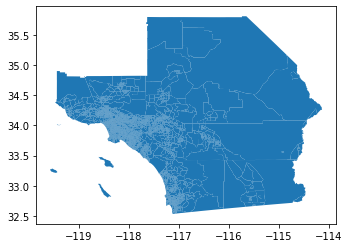

In [19]:
scag.plot()

Note that the tract identifier column is `geoid` which encodes the [11-digit FIPS code](https://www.fcc.gov/general/form-477-census-tract-information).

## Reading shapefiles

[shapefiles](https://doc.arcgis.com/en/arcgis-online/reference/shapefiles.htm) are a common legacy spatial data format for vector data. 
Let's explore a second data set that encodes mental health provider locations in Riverside County, California as points in a shapefile:

### Reading a point shapefile

In [20]:
clinics_df = gpd.read_file('data/behavioralHealth.shp')
clinics_df.columns

Index(['OBJECTID', 'SITE_TYPE', 'SITE_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'PHONE', 'geometry'],
      dtype='object')

In [21]:
clinics_df.head()

,OBJECTID,SITE_TYPE,SITE_NAME,ADDRESS,CITY,ZIPCODE,PHONE,geometry
0,149.0,Behavioral Health,Older Adult Services,6355 Riverside Ave,Riverside,92506,951-369-0219,POINT (6216487.156 2291913.664)
1,150.0,Behavioral Health,Children'S Treatment Services,9990 County Farm Rd,Riverside,92503,951-358-4840,POINT (6195566.226 2280519.190)
2,151.0,Behavioral Health,"Family, Adolescent, And Children'S Treatment",1195 Magnolia Ave,Corona,91719,951-273-0608,POINT (6168252.101 2261023.951)
3,447.0,Behavioral Health,Blythe Clinic,1297 W Hobson Way,Blythe,92225,760-770-2222,POINT (7059944.605 2169652.046)
4,152.0,Behavioral Health,Interagency Services For Families,9890 County Farm Rd,Riverside,92503,951-358-4850,POINT (6195949.672 2280510.302)


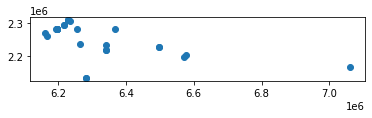

In [22]:
clinics_df.plot()

In [23]:
clinics_df.geometry

0     POINT (6216487.156 2291913.664)
1     POINT (6195566.226 2280519.190)
2     POINT (6168252.101 2261023.951)
3     POINT (7059944.605 2169652.046)
4     POINT (6195949.672 2280510.302)
5     POINT (6195566.226 2280519.190)
6     POINT (6255240.101 2281392.265)
7     POINT (6162865.861 2269381.489)
8     POINT (6195182.779 2280509.032)
9     POINT (6342387.266 2220024.356)
10    POINT (6195566.226 2280519.190)
11    POINT (6577094.185 2205388.907)
12    POINT (6195566.226 2280519.190)
13    POINT (6283871.161 2136729.378)
14    POINT (6229918.194 2307140.803)
15    POINT (6496477.603 2228753.546)
16    POINT (6342390.651 2220029.434)
17    POINT (6265042.293 2237006.918)
18    POINT (6341877.001 2233915.961)
19    POINT (6283867.341 2136731.288)
20    POINT (6367147.411 2280861.442)
21    POINT (6496480.142 2228757.355)
22    POINT (6570450.368 2198847.190)
23    POINT (6234956.516 2303352.150)
24    POINT (6195566.226 2280520.460)
25    POINT (6216489.695 2291912.394)
26    POINT 

In [24]:
clinics_df.ADDRESS

0         6355 Riverside Ave
1        9990 County Farm Rd
2          1195 Magnolia Ave
3          1297 W Hobson Way
4        9890 County Farm Rd
5        9990 County Farm Rd
6       23119 Cottonwood Ave
7              623 N Main St
8       10000 County Farm Rd
9             650 N State St
10       9990 County Farm Rd
11             83-912 Ave 45
12       9990 County Farm Rd
13    41002 County Center Dr
14          1827 Atlanta Ave
15           68-615 Perez Rd
16            650 N State St
17        1688 N Perris Blvd
18         950 N Ramona Blvd
19    41002 County Center Dr
20          1330 W Ramsey St
21           68-615 Perez Rd
22           47-825 Oasis St
23             769 Blaine St
24       9990 County Farm Rd
25        6355 Riverside Ave
26          1827 Atlanta Ave
27          1827 Atlanta Ave
Name: ADDRESS, dtype: object

In [25]:
len(clinics_df.ADDRESS.unique()) # note some clinics have the same address (different types of services provided at same location)

18

## Integrating spatial datasets
Let's assume the role of a public health epidemiologist who is interested in equity issues surrounding access to mental health services. We have two datasets to work with here:

- the clinics (points in Riverside County)
- the tracts for all of Southern California

We will thus want to narrow down the focus to Riverside county. So first, we need to extract the tracts for the county from the larger region:


## Extracting Riverside County Tracts

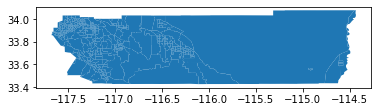

In [26]:
rc = scag[scag['geoid'].str.match("^06065")]

rc.plot()

## Spatial Joins

With the two datasets in hand, we would like to know the answer to the following question:

> How many clinics are in each census tract in Riverside County?

To get at this answer will can use a [spatial join](https://gisgeography.com/spatial-join/). 
The idea here is to create a linkage between each clinic (point) and the tract (polygon) that the clinic lies within.

The answer to our question will be the number of matches found for each census tract.

In geopandas the spatial join is done with the `sjoin` method of the GeoDataFrame:


In [27]:
clinics_tracts = gpd.sjoin(clinics_df, rc, op='within')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2230
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


We see a warning here, that alerts us to a mismatch between the CRS: [Coordinate Reference Systems](https://www.w3.org/2015/spatial/wiki/Coordinate_Reference_Systems) of the two GeoDataFrames. We can inspect these to see what is going on:

In [28]:
clinics_df.crs

<Projected CRS: EPSG:2230>
Name: NAD83 / California zone 6 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - California - SPCS - 6
- bounds: (-118.15, 32.53, -114.42, 34.08)
Coordinate Operation:
- name: SPCS83 California zone 6 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [29]:
rc.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

So the clinics have a unit of feet, while the tracts are in degrees. The spatial join will be incorrect because of this since the observations from the two dataframes are in different coordinate systems:

In [30]:
clinics_tracts

,OBJECTID,SITE_TYPE,SITE_NAME,ADDRESS,CITY,ZIPCODE,PHONE,geometry,index_right,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,n_native_over_60,n_persons_over_60,n_white_over_60,n_asian_over_65,n_black_over_65,n_hispanic_over_65,n_native_over_65,n_white_over_65,n_persons_over_75,n_persons_over_15,n_civilians_over_16,n_civilians_over_18,n_persons_over_25,n_age_5_older,n_asian_age_distribution,n_black_age_distribution,n_hispanic_age_distribution,n_native_age_distribution,n_white_age_distribution,n_asian_persons,n_black_persons,...,p_other_language,n_total_pop,p_owner_occupied_units,p_poverty_rate,p_puerto_rican_pop,p_employed_professional,n_puerto_rican_pop,n_employed_professional,p_russian_pop,p_russian_born_pop,p_scandanavian_pop,p_scandanavian_born_pop,p_employed_self_employed,p_unemployment_rate,p_vacant_housing_units,p_veterans,p_vietnamese_persons,p_widowed_divorced,p_poverty_rate_white,n_renter_occupied_housing_units,n_russian_pop,n_russian_born_pop,n_scandaniavian_pop,n_scandaniavian__born_pop,n_employed_self_employed,n_unemployed_persons,n_vacant_housing_units,n_veterans,n_vietnamese_persons,n_widowed_divorced,n_white_persons,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled


To rectify this, we need to have both GeoDataFrames in the same CRS. Let's change the CRS of the tracts GeoDataFrame which is currently:


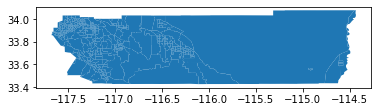

In [31]:
rc.plot()

To change this, we notice the helpful suggestion in the warning above to use the `to_crs` method. Let's try it to see how this works:

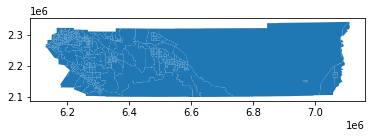

In [32]:
rc.to_crs(clinics_df.crs).plot()

Comparison of the two plots shows us that the CRS has been changed. We did not assign the object yet (which is good practice when experimenting). But it does what we need, so lets assign the result to redefine our tracts GeoDataFrame:

In [33]:
rc = rc.to_crs(clinics_df.crs)

In [34]:
clinics_tracts = gpd.sjoin(clinics_df, rc, op='within')

In [35]:
clinics_tracts

,OBJECTID,SITE_TYPE,SITE_NAME,ADDRESS,CITY,ZIPCODE,PHONE,geometry,index_right,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,n_native_over_60,n_persons_over_60,n_white_over_60,n_asian_over_65,n_black_over_65,n_hispanic_over_65,n_native_over_65,n_white_over_65,n_persons_over_75,n_persons_over_15,n_civilians_over_16,n_civilians_over_18,n_persons_over_25,n_age_5_older,n_asian_age_distribution,n_black_age_distribution,n_hispanic_age_distribution,n_native_age_distribution,n_white_age_distribution,n_asian_persons,n_black_persons,...,p_other_language,n_total_pop,p_owner_occupied_units,p_poverty_rate,p_puerto_rican_pop,p_employed_professional,n_puerto_rican_pop,n_employed_professional,p_russian_pop,p_russian_born_pop,p_scandanavian_pop,p_scandanavian_born_pop,p_employed_self_employed,p_unemployment_rate,p_vacant_housing_units,p_veterans,p_vietnamese_persons,p_widowed_divorced,p_poverty_rate_white,n_renter_occupied_housing_units,n_russian_pop,n_russian_born_pop,n_scandaniavian_pop,n_scandaniavian__born_pop,n_employed_self_employed,n_unemployed_persons,n_vacant_housing_units,n_veterans,n_vietnamese_persons,n_widowed_divorced,n_white_persons,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled
0,149.0,Behavioral Health,Older Adult Services,6355 Riverside Ave,Riverside,92506,951-369-0219,POINT (6216487.156 2291913.664),661,06065031100,0.0,35.0,686.0,0.0,322.0,1383.0,None,None,None,None,827.0,None,0.0,83.0,100.0,0.0,471.0,364.0,3555.0,None,3365.0,3138.0,4303.0,44.0,245.0,1902.0,19.0,2339.0,44.0,None,...,18.432114,4758.0,95.860058,10.832059,1.597310,36.185948,76.0,685.0,0.000000,0.000000,3.068516,0.000000,9.984152,10.851582,4.139942,7.629256,0.000000,22.812940,2.140205,696.0,0.0,0.0,146.0,0.0,189.0,223.0,71.0,363.0,0.0,811.0,None,2010,1715.0,49.159311,None,None,None,None,None,None
25,146.0,Behavioral Health,Adult Mental Health Services - Central Clinic,6355 Riverside Ave,Riverside,92506,951-369-5714,POINT (6216489.695 2291912.394),661,06065031100,0.0,35.0,686.0,0.0,322.0,1383.0,None,None,None,None,827.0,None,0.0,83.0,100.0,0.0,471.0,364.0,3555.0,None,3365.0,3138.0,4303.0,44.0,245.0,1902.0,19.0,2339.0,44.0,None,...,18.432114,4758.0,95.860058,10.832059,1.597310,36.185948,76.0,685.0,0.000000,0.000000,3.068516,0.000000,9.984152,10.851582,4.139942,7.629256,0.000000,22.812940,2.140205,696.0,0.0,0.0,146.0,0.0,189.0,223.0,71.0,363.0,0.0,811.0,None,2010,1715.0,49.159311,None,None,None,None,None,None
1,150.0,Behavioral Health,Children'S Treatment Services,9990 County Farm Rd,Riverside,92503,951-358-4840,POINT (6195566.226 2280519.190),1798,06065041201,66.0,14.0,704.0,0.0,94.0,1235.0,None,None,None,None,607.0,None,64.0,12.0,94.0,0.0,239.0,205.0,2888.0,None,2531.0,2217.0,3609.0,497.0,60.0,2248.0,0.0,973.0,497.0,None,...,57.355284,3766.0,89.515419,25.014459,0.000000,23.064516,0.0,286.0,0.000000,0.000000,1.168348,0.000000,13.145161,13.018598,10.484581,6.266596,1.938396,22.506925,2.805090,316.0,0.0,0.0,44.0,0.0,163.0,182.0,119.0,236.0,73.0,650.0,None,2010,1135.0,25.836431,None,None,None,None,None,None
4,152.0,Behavioral Health,Interagency Services For Families,9890 County Farm Rd,Riverside,92503,951-358-4850,POINT (6195949.672 2280510.302),1798,06065041201,66.0,14.0,704.0,0.0,94.0,1235.0,None,None,None,None,607.0,None,64.0,12.0,94.0,0.0,239.0,205.0,2888.0,None,2531.0,2217.0,3609.0,497.0,60.0,2248.0,0.0,973.0,497.0,None,...,57.355284,3766.0,89.515419,25.014459,0.000000,23.064516,0.0,286.0,0.000000,0.000000,1.168348,0.000000,13.145161,13.018598,10.484581,6.266596,1.938396,22.506925,2.805090,316.0,0.0,0.0,44.0,0.0,163.0,182.0,119.0,236.0,73.0,650.0,None,2010,1135.0,25.836431,None,None,None,None,None,None
5,448.0,Behavioral Health,Children'S Evaluation Services Unite,9990 County Farm Rd,Riverside,92503,951-358-7380,POINT (6195566.226 2280519.190

Now we see the spatial join has worked. There are 28 matches (one for each clinic) and this is stored in a new GeoDataFrame called: `clinics_tracts`.

## Determine the number of clinics in each tract

Returning to our question, we can find the number of clinics in each of the tracts in this new GeoDataFrame by using the `group_by` method:

In [36]:
clinics_tracts[['geoid', 'index_right']].groupby('geoid').agg('count')

,index_right
geoid,
06065031100,2
06065040809,1
06065041201,7
06065041813,1
06065042209,3
06065042210,1
06065042512,1
06065042620,1
06065043507,2


This works, so let's create another DataFrame to store these counts:

In [37]:
ct = clinics_tracts[['geoid', 'index_right']].groupby('geoid').agg('count')
ct.shape

(16, 1)

## Table Join



We now know for the tracts that contain at least one clinic, how many clinics they contain. This implies that the tracts that are not in the `ct` GeoDataFrame do not contain a clinic. What we would like to have is an additional attribute on our `rc` tracts GeoDataFrame that stores the number of clinics in each tract - for all tracts in Riverside County.

We can do this in two remaining steps:

- a table join on the `geoid` column 
- setting NA values to 0

In [38]:
rc.merge(ct, on='geoid')

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,n_native_over_60,n_persons_over_60,n_white_over_60,n_asian_over_65,n_black_over_65,n_hispanic_over_65,n_native_over_65,n_white_over_65,n_persons_over_75,n_persons_over_15,n_civilians_over_16,n_civilians_over_18,n_persons_over_25,n_age_5_older,n_asian_age_distribution,n_black_age_distribution,n_hispanic_age_distribution,n_native_age_distribution,n_white_age_distribution,n_asian_persons,n_black_persons,n_chinese_persons,n_labor_force,n_civilians_16_64,n_edu_college_greater,n_cuban_pop,n_poverty_determined_asian,n_poverty_determined_black,n_total_pop_sample,n_female_over_16,...,p_owner_occupied_units,p_poverty_rate,p_puerto_rican_pop,p_employed_professional,n_puerto_rican_pop,n_employed_professional,p_russian_pop,p_russian_born_pop,p_scandanavian_pop,p_scandanavian_born_pop,p_employed_self_employed,p_unemployment_rate,p_vacant_housing_units,p_veterans,p_vietnamese_persons,p_widowed_divorced,p_poverty_rate_white,n_renter_occupied_housing_units,n_russian_pop,n_russian_born_pop,n_scandaniavian_pop,n_scandaniavian__born_pop,n_employed_self_employed,n_unemployed_persons,n_vacant_housing_units,n_veterans,n_vietnamese_persons,n_widowed_divorced,n_white_persons,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry,index_right
0,06065042210,14.0,4.0,392.0,0.0,49.0,626.0,None,None,None,None,281.0,None,0.0,64.0,31.0,0.0,42.0,30.0,3665.0,None,3572.0,1994.0,3979.0,741.0,540.0,1693.0,22.0,1104.0,741.0,None,329.0,2492.0,None,595.0,22.0,621.0,516.0,None,1816.0,...,78.798241,30.925222,0.190250,37.131367,8.0,831.0,0.000000,0.000000,1.712247,0.000000,1.831993,10.674157,21.201759,5.112961,1.331748,9.713506,7.832700,1413.0,0.0,0.0,72.0,0.0,41.0,266.0,434.0,215.0,56.0,356.0,None,2010,2047.0,26.254459,None,None,None,None,None,None,"POLYGON ((6231281.704 2304380.325, 6231334.275...",1
1,06065044101,0.0,0.0,441.0,0.0,90.0,643.0,None,None,None,None,376.0,None,0.0,19.0,106.0,0.0,135.0,53.0,1928.0,None,1816.0,1627.0,2329.0,89.0,113.0,1360.0,37.0,861.0,89.0,None,4.0,1051.0,None,151.0,0.0,89.0,113.0,None,915.0,...,81.766149,32.126881,0.000000,17.599068,0.0,151.0,0.000000,0.000000,1.464010,0.000000,7.109557,18.934348,18.233851,7.808052,0.000000,21.109959,8.255388,633.0,0.0,0.0,36.0,0.0,61.0,199.0,223.0,192.0,0.0,407.0,None,2010,1223.0,35.014233,None,None,None,None,None,None,"POLYGON ((6360916.988 2282317.240, 6368904.754...",1
2,06065046102,0.0,16.0,409.0,0.0,8.0,500.0,None,None,None,None,240.0,None,0.0,44.0,111.0,5.0,49.0,51.0,1405.0,None,1326.0,1067.0,1629.0,74.0,130.0,1381.0,19.0,259.0,74.0,None,0.0,759.0,None,114.0,0.0,66.0,88.0,None,616.0,...,66.741826,28.455285,0.164294,17.528736,3.0,122.0,0.000000,0.000000,1.423877,0.000000,0.862069,8.300395,33.258174,0.821468,0.000000,23.274021,4.190119,426.0,0.0,0.0,26.0,0.0,6.0,63.0,295.0,15.0,0.0,327.0,None,2010,887.0,14.184009,None,None,None,None,None,None,"POLYGON ((7056901.702 2172059.918, 7059550.089...",1
3,06065041813,22.0,0.0,1385.0,0.0,218.0,2055.0,None,None,None,None,1078.0,None,30.0,40.0,241.0,20.0,505.0,445.0,5061.0,None,4673.0,4049.0,6203.0,108.0,123.0,4437.0,29.0,1930.0,108.0,None,0.0,3058.0,None,610.0,0.0,91.0,119.0,None,2525.0,...,92.562380,17.166463,0.772889,17.841497,52.0,448.0,0.416171,0.000000,1.070155,0.000000,8.004779,18.705036,7.437620,4.860285,0.000000,20.035566,2.417381,935.0,28.0,0.0,72.0,0.0,201.0,572.0,155.0,327.0,0.0,1014.0,None,2010,2084.0,28.686088,None,None,None,None,None,None,"POLYGON ((6163401.241 2262775.155, 6163930.681...",1
4,06065031100,0.0,35.0,686.0,0.0,322.0,1383.0,None,None,None,None,827.0,None,0.0,83.0,100.0,0.0,471.0,364.0,3555.0,None,3365.0,3138.0,4303.0,44.0,245.0,1902.0,19.0,2339.0,44.0,None,0.0,2055.0,None,678.0,9.0,36.0,239.0,None,1934.0,...,95.860058,10.832059,1.597310,36.185948,76.0,685.0,0.000000

Note that this isn't quite what we want as it only matches the 16 tracts containing clinics. We can change the `how` argument to `outer` to include all tracts:

In [39]:
rc.merge(ct, on='geoid', how='outer')

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,n_native_over_60,n_persons_over_60,n_white_over_60,n_asian_over_65,n_black_over_65,n_hispanic_over_65,n_native_over_65,n_white_over_65,n_persons_over_75,n_persons_over_15,n_civilians_over_16,n_civilians_over_18,n_persons_over_25,n_age_5_older,n_asian_age_distribution,n_black_age_distribution,n_hispanic_age_distribution,n_native_age_distribution,n_white_age_distribution,n_asian_persons,n_black_persons,n_chinese_persons,n_labor_force,n_civilians_16_64,n_edu_college_greater,n_cuban_pop,n_poverty_determined_asian,n_poverty_determined_black,n_total_pop_sample,n_female_over_16,...,p_owner_occupied_units,p_poverty_rate,p_puerto_rican_pop,p_employed_professional,n_puerto_rican_pop,n_employed_professional,p_russian_pop,p_russian_born_pop,p_scandanavian_pop,p_scandanavian_born_pop,p_employed_self_employed,p_unemployment_rate,p_vacant_housing_units,p_veterans,p_vietnamese_persons,p_widowed_divorced,p_poverty_rate_white,n_renter_occupied_housing_units,n_russian_pop,n_russian_born_pop,n_scandaniavian_pop,n_scandaniavian__born_pop,n_employed_self_employed,n_unemployed_persons,n_vacant_housing_units,n_veterans,n_vietnamese_persons,n_widowed_divorced,n_white_persons,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry,index_right
0,06065042005,7.0,157.0,259.0,0.0,540.0,1472.0,None,None,None,None,625.0,None,26.0,25.0,3.0,0.0,364.0,179.0,4155.0,None,3706.0,3134.0,4791.0,542.0,602.0,1166.0,47.0,2705.0,542.0,None,24.0,2767.0,None,1113.0,32.0,542.0,587.0,None,2014.0,...,94.440768,4.234654,0.289687,41.568329,15.0,1092.0,0.772499,0.0,2.201622,0.0,19.413780,7.517167,5.559232,4.036307,0.656624,9.145608,1.592852,134.0,40.0,0.0,114.0,0.0,510.0,208.0,84.0,209.0,34.0,380.0,None,2010,1511.0,52.240247,None,None,None,None,None,None,"POLYGON ((6220451.886 2273544.863, 6222975.821...",NaN
1,06065042210,14.0,4.0,392.0,0.0,49.0,626.0,None,None,None,None,281.0,None,0.0,64.0,31.0,0.0,42.0,30.0,3665.0,None,3572.0,1994.0,3979.0,741.0,540.0,1693.0,22.0,1104.0,741.0,None,329.0,2492.0,None,595.0,22.0,621.0,516.0,None,1816.0,...,78.798241,30.925222,0.190250,37.131367,8.0,831.0,0.000000,0.0,1.712247,0.0,1.831993,10.674157,21.201759,5.112961,1.331748,9.713506,7.832700,1413.0,0.0,0.0,72.0,0.0,41.0,266.0,434.0,215.0,56.0,356.0,None,2010,2047.0,26.254459,None,None,None,None,None,None,"POLYGON ((6231281.704 2304380.325, 6231334.275...",1.0
2,06065042403,10.0,62.0,604.0,0.0,142.0,1153.0,None,None,None,None,670.0,None,11.0,65.0,238.0,0.0,182.0,242.0,3354.0,None,3031.0,2571.0,3877.0,123.0,378.0,2432.0,0.0,1136.0,113.0,None,10.0,1939.0,None,325.0,0.0,123.0,352.0,None,1653.0,...,93.551089,10.907778,1.407779,30.333899,59.0,536.0,0.000000,0.0,0.000000,0.0,6.451613,9.437855,6.448911,5.845860,0.739680,10.882528,2.191187,158.0,0.0,0.0,0.0,0.0,114.0,183.0,77.0,245.0,31.0,365.0,None,2010,1194.0,27.105703,None,None,None,None,None,None,"POLYGON ((6265534.814 2293274.461, 6268193.946...",NaN
3,06065042405,17.0,570.0,877.0,0.0,140.0,1949.0,None,None,None,None,341.0,None,0.0,58.0,92.0,0.0,50.0,96.0,3820.0,None,3548.0,2601.0,4799.0,63.0,1998.0,2490.0,14.0,697.0,50.0,None,0.0,2309.0,None,221.0,0.0,63.0,1995.0,None,2197.0,...,90.612245,39.923049,0.818628,14.692218,45.0,253.0,0.000000,0.0,0.345643,0.0,3.484321,25.595496,9.387755,2.474077,0.090959,22.277487,4.488824,1559.0,0.0,0.0,19.0,0.0,60.0,591.0,184.0,136.0,5.0,851.0,None,2010,1960.0,12.679643,None,None,None,None,None,None,"POLYGON ((6254901.013 2289559.243, 6257552.324...",NaN
4,06065042507,6.0,196.0,1132.0,0.0,47.0,1778.0,None,None,None,None,586.0,None,57.0,172.0,51.0,0.0,102.0,234.0,3541.0,None,3242.0,2612.0,4535.0,149.0,836.0,3194.0,0.0,602.0,149.0,None,0.0,1950.0,None,221.0,14.0,149.0,804.0,None,1877.0,...,89.330025,18.082699,3.001391,20.662651,151.0,343.0,0.000000,0.

Ok now we have all the tracts covered. But if you scroll to the right we will see `NaN` values for the tracts that do not contain a clinic. What remains is to replace the 

In [40]:
rc.merge(ct, on='geoid', how='outer').fillna(0)

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,n_native_over_60,n_persons_over_60,n_white_over_60,n_asian_over_65,n_black_over_65,n_hispanic_over_65,n_native_over_65,n_white_over_65,n_persons_over_75,n_persons_over_15,n_civilians_over_16,n_civilians_over_18,n_persons_over_25,n_age_5_older,n_asian_age_distribution,n_black_age_distribution,n_hispanic_age_distribution,n_native_age_distribution,n_white_age_distribution,n_asian_persons,n_black_persons,n_chinese_persons,n_labor_force,n_civilians_16_64,n_edu_college_greater,n_cuban_pop,n_poverty_determined_asian,n_poverty_determined_black,n_total_pop_sample,n_female_over_16,...,p_owner_occupied_units,p_poverty_rate,p_puerto_rican_pop,p_employed_professional,n_puerto_rican_pop,n_employed_professional,p_russian_pop,p_russian_born_pop,p_scandanavian_pop,p_scandanavian_born_pop,p_employed_self_employed,p_unemployment_rate,p_vacant_housing_units,p_veterans,p_vietnamese_persons,p_widowed_divorced,p_poverty_rate_white,n_renter_occupied_housing_units,n_russian_pop,n_russian_born_pop,n_scandaniavian_pop,n_scandaniavian__born_pop,n_employed_self_employed,n_unemployed_persons,n_vacant_housing_units,n_veterans,n_vietnamese_persons,n_widowed_divorced,n_white_persons,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry,index_right
0,06065042005,7.0,157.0,259.0,0.0,540.0,1472.0,0,0,0,0,625.0,0,26.0,25.0,3.0,0.0,364.0,179.0,4155.0,0,3706.0,3134.0,4791.0,542.0,602.0,1166.0,47.0,2705.0,542.0,0,24.0,2767.0,0,1113.0,32.0,542.0,587.0,0,2014.0,...,94.440768,4.234654,0.289687,41.568329,15.0,1092.0,0.772499,0.0,2.201622,0.0,19.413780,7.517167,5.559232,4.036307,0.656624,9.145608,1.592852,134.0,40.0,0.0,114.0,0.0,510.0,208.0,84.0,209.0,34.0,380.0,0,2010,1511.0,52.240247,0,0,0,0,0,0,"POLYGON ((6220451.886 2273544.863, 6222975.821...",0.0
1,06065042210,14.0,4.0,392.0,0.0,49.0,626.0,0,0,0,0,281.0,0,0.0,64.0,31.0,0.0,42.0,30.0,3665.0,0,3572.0,1994.0,3979.0,741.0,540.0,1693.0,22.0,1104.0,741.0,0,329.0,2492.0,0,595.0,22.0,621.0,516.0,0,1816.0,...,78.798241,30.925222,0.190250,37.131367,8.0,831.0,0.000000,0.0,1.712247,0.0,1.831993,10.674157,21.201759,5.112961,1.331748,9.713506,7.832700,1413.0,0.0,0.0,72.0,0.0,41.0,266.0,434.0,215.0,56.0,356.0,0,2010,2047.0,26.254459,0,0,0,0,0,0,"POLYGON ((6231281.704 2304380.325, 6231334.275...",1.0
2,06065042403,10.0,62.0,604.0,0.0,142.0,1153.0,0,0,0,0,670.0,0,11.0,65.0,238.0,0.0,182.0,242.0,3354.0,0,3031.0,2571.0,3877.0,123.0,378.0,2432.0,0.0,1136.0,113.0,0,10.0,1939.0,0,325.0,0.0,123.0,352.0,0,1653.0,...,93.551089,10.907778,1.407779,30.333899,59.0,536.0,0.000000,0.0,0.000000,0.0,6.451613,9.437855,6.448911,5.845860,0.739680,10.882528,2.191187,158.0,0.0,0.0,0.0,0.0,114.0,183.0,77.0,245.0,31.0,365.0,0,2010,1194.0,27.105703,0,0,0,0,0,0,"POLYGON ((6265534.814 2293274.461, 6268193.946...",0.0
3,06065042405,17.0,570.0,877.0,0.0,140.0,1949.0,0,0,0,0,341.0,0,0.0,58.0,92.0,0.0,50.0,96.0,3820.0,0,3548.0,2601.0,4799.0,63.0,1998.0,2490.0,14.0,697.0,50.0,0,0.0,2309.0,0,221.0,0.0,63.0,1995.0,0,2197.0,...,90.612245,39.923049,0.818628,14.692218,45.0,253.0,0.000000,0.0,0.345643,0.0,3.484321,25.595496,9.387755,2.474077,0.090959,22.277487,4.488824,1559.0,0.0,0.0,19.0,0.0,60.0,591.0,184.0,136.0,5.0,851.0,0,2010,1960.0,12.679643,0,0,0,0,0,0,"POLYGON ((6254901.013 2289559.243, 6257552.324...",0.0
4,06065042507,6.0,196.0,1132.0,0.0,47.0,1778.0,0,0,0,0,586.0,0,57.0,172.0,51.0,0.0,102.0,234.0,3541.0,0,3242.0,2612.0,4535.0,149.0,836.0,3194.0,0.0,602.0,149.0,0,0.0,1950.0,0,221.0,14.0,149.0,804.0,0,1877.0,...,89.330025,18.082699,3.001391,20.662651,151.0,343.0,0.000000,0.0,0.357782,0.0,6.325301,14.871795,10.669975,4.810177,1.073345,16.633719,0.308578,308.0,0.0,0.0,18.0,0.0,105.0,290.0,129.0,242.0,54.0,589.0,0,2010,1209.0,11.965812,0,0,0,0,0,0,"POLYGON ((6260074.881 2265634.857, 6260130.

Great. Now we save our work and rename the column holding the clinic count:

In [41]:
rc = rc.merge(ct, on='geoid', how='outer').fillna(0)

In [42]:
rc['index_right'].sum()

28.0

In [43]:
rc.rename(columns={'index_right': 'clinics'}, inplace=True)

In [44]:
rc.clinics.sum()

28.0

In [45]:
type(rc)

geopandas.geodataframe.GeoDataFrame

<div class="alert alert-success" style="font-size:120%">
<b>Exercise</b>: <br>
Create a shapefile for each of the counties in the Southern California dataframe, and write to <code>data/FIPSCODE.shp</code>. Where <code>FIPSCODE</code> is the 5-digit
<a href="https://www.nrcs.usda.gov/wps/portal/nrcs/detail/ca/home/?cid=nrcs143_013697">FIPS Code for the county</a>.
</div>

In [ ]:
# %load solutions/00.py

In [46]:
scag['county'] = scag.geoid.str[:5]     # add a column with the derived fips codes for a tract's county
counties = scag.county.unique()         # get the unique county codes
for county in counties:                 # loop over the counties and create the shapefiles
    gdf = scag[scag.county==county]
    gdf.to_file(f'data/{county}.shp')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """


---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-
sa/4.0/"><img alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geoprocessing</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://sergerey.org" property="cc:attributionName"
rel="cc:attributionURL">Serge Rey</a> is licensed under a <a
rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.